In [ ]:
# If running with Google Colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dataFolder = '/content/drive/My Drive/1970513_LanguageModel/'
import os
os.chdir(dataFolder) # change the current working directory

# Run this script to start training from scratch

In [1]:
!rm /content/drive/My\ Drive/1970513_LanguageModel/*char_sequences.txt
!rm -rf /content/drive/My\ Drive/1970513_LanguageModel/savedEpochs/*
!rm -rf /content/drive/My\ Drive/1970513_LanguageModel/std_model/*
!rm -rf /content/drive/My\ Drive/1970513_LanguageModel/bi_model/*

rm: cannot remove '/content/drive/My Drive/1970513_LanguageModel/*char_sequences.txt': No such file or directory


In [ ]:
import os
import re
import numpy as np
import argparse
import pickle
import codecs
import pandas as pd
import random
%tensorflow_version 1.x
import tensorflow as tf
from matplotlib import pyplot as plt
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM, Embedding
from keras.layers import Bidirectional
from keras.callbacks import ModelCheckpoint
from keras.backend.tensorflow_backend import set_session

TensorFlow 1.x selected.


Using TensorFlow backend.


In [ ]:
# for tensor 1
config = tf.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
sess = tf.Session(config=config)
set_session(sess)
print("use-gpu:", tf.test.gpu_device_name())
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

use-gpu: /device:GPU:0
Num GPUs Available:  1


# Data preparation

In [ ]:
data_mode = 1
eos = "}"
bos = "{"
corpusFile = "full_name.csv" # not yet augmented
seq_length = 15
epochs = 40
part_size = 1000000
batch_size = 256
period = 5


if data_mode == '0':
  corpusSequenceFile = "_" + corpusFile[:-4] + "_" + "char_sequences.txt" # no upper case
  name_mapping_file = '_name_data_mapping.pkl'
else:
  corpusSequenceFile = corpusFile[:-4] + "_" + "char_sequences.txt" # with upper case
  name_mapping_file = 'name_data_mapping.pkl'

print(corpusSequenceFile)
print(name_mapping_file)

full_name_char_sequences.txt
name_data_mapping.pkl


In [ ]:
def checkCorpus(string):
    currentDir = os.listdir()
    if (string in currentDir and os.path.isfile(string)):
        return string
    else:
        # print("No folder named %s" % string)
        return -1

def data_cleaner(data, upper=1):
    temp = []
    for ele in data:
      new_ele = bos + ele + eos
      if upper:
        temp.append(new_ele)
      else:
        temp.append(new_ele.lower())
    newData = " ".join(temp).strip()
    import pdb; pdb.set_trace()
    # remove punctuations
    # INTAB = "ạảãàáâậầấẩẫăắằặẳẵóòọõỏôộổỗồốơờớợởỡéèẻẹẽêếềệểễúùụủũưựữửừứíìịỉĩýỳỷỵỹđẠẢÃÀÁÂẬẦẤẨẪĂẮẰẶẲẴÓÒỌÕỎÔỘỔỖỒỐƠỜỚỢỞỠÉÈẺẸẼÊẾỀỆỂỄÚÙỤỦŨƯỰỮỬỪỨÍÌỊỈĨÝỲỶỴỸĐ"
    newData = re.sub("[^{}a-zA-ZạảãàáâậầấẩẫăắằặẳẵóòọõỏôộổỗồốơờớợởỡéèẻẹẽêếềệểễúùụủũưựữửừứíìịỉĩýỳỷỵỹđẠẢÃÀÁÂẬẦẤẨẪĂẮẰẶẲẴÓÒỌÕỎÔỘỔỖỒỐƠỜỚỢỞỠÉÈẺẸẼÊẾỀỆỂỄÚÙỤỦŨƯỰỮỬỪỨÍÌỊỈĨÝỲỶỴỸĐ]", " ", newData)
    long_words=[]
    # remove short word
    for i in newData.split():
      if len(i)>=1:
        long_words.append(i)
    return (" ".join(long_words)).strip()

# load csv
def load_original_csv(filename):
    # open the file as read only
    file = codecs.open(filename, 'r', encoding='utf-8')
    # read all text

    dataframe = pd.read_csv(filename)
    full_name = dataframe['Full name'].to_list()
      # close the file
    file.close()
    return full_name 

# load doc into memory
def load_data(filename):
	# open the file as read only
	file = open(filename, 'r', encoding='utf-8')
	# read all text
	text = file.read()
	# close the file
	file.close()
	return text

# save tokens to file, one dialog per line
def save_data(lines, filename):
	data = '\n'.join(lines)
	file = open(filename, 'w', encoding='utf-8')
	file.write(data)
	file.close()
 
def create_seq(orgText, length, reverted=False):
    text = orgText[::-1] if reverted == True else orgText
    sequences = list()
    for i in range(length, len(text)):
        seq = text[i-length:i+1]
        sequences.append(seq)
    print('Total Sequences: %d' % len(sequences))
    return sequences

def constrain(x, min, max):
    if x < min:
        return min
    elif x > max:
        return max
    else:
        return x

def data_augmentation(raw_data):
  import pdb; pdb.set_trace()
  new_data = []
  for item in raw_data:
    items = [item]*20
    new_data.append(items)
  random.shuffle(new_data)
  return raw_data + new_data

In [ ]:
if (not os.path.exists(corpusSequenceFile)):
    # load orginal csv
    raw_data = load_original_csv(corpusFile)
    # augmentation 
    aug_data = data_augmentation(raw_data)
    # clean
    clean_data = data_cleaner(raw_data, upper=data_mode)
    # organize into sequences of characters
    sequences = create_seq(clean_data, seq_length)

    # save sequences to file
    save_data(sequences, corpusSequenceFile)

    # load
raw_data = load_data(corpusSequenceFile)
lines = raw_data.split('\n')

chars = sorted(list(set(raw_data)))
mapping = dict((c, i) for i, c in enumerate(chars))

# save the mapping
pickle.dump(mapping, open(name_mapping_file, 'wb'))

sequences = list()
for line in lines:
	# integer encode line
	encoded_seq = [mapping[char] for char in line]
	# store
	sequences.append(encoded_seq)

# vocabulary size
vocab_size = len(mapping)
print('Vocabulary Size: %d' % vocab_size)


sequences = np.array(sequences)
X_train, y_train = sequences[:,:-1].copy(), sequences[:,-1].copy()


input_shape = (seq_length, vocab_size)
current_part = 0
max_part = int(len(X_train) / part_size) + 1
lastEpoch = 0
# if (os.path.exists('savedEpochs/current_part.txt')):
#     with open('savedEpochs/current_part.txt', 'r', encoding='utf8') as f:
#         current_part = int(f.read())

Vocabulary Size: 125


In [ ]:
print(lines[1:100])
print(sequences[1:100])

['Nguyễn Thị Như Q', 'guyễn Thị Như Qu', 'uyễn Thị Như Quỳ', 'yễn Thị Như Quỳn', 'ễn Thị Như Quỳnh', 'n Thị Như Quỳnh}', ' Thị Như Quỳnh} ', 'Thị Như Quỳnh} {', 'hị Như Quỳnh} {L', 'ị Như Quỳnh} {Lê', ' Như Quỳnh} {Lê ', 'Như Quỳnh} {Lê H', 'hư Quỳnh} {Lê Ho', 'ư Quỳnh} {Lê Hoà', ' Quỳnh} {Lê Hoàn', 'Quỳnh} {Lê Hoàng', 'uỳnh} {Lê Hoàng ', 'ỳnh} {Lê Hoàng Q', 'nh} {Lê Hoàng Qu', 'h} {Lê Hoàng Quâ', '} {Lê Hoàng Quân', ' {Lê Hoàng Quân}', '{Lê Hoàng Quân} ', 'Lê Hoàng Quân} {', 'ê Hoàng Quân} {Đ', ' Hoàng Quân} {Đi', 'Hoàng Quân} {Đin', 'oàng Quân} {Đinh', 'àng Quân} {Đinh ', 'ng Quân} {Đinh V', 'g Quân} {Đinh Vă', ' Quân} {Đinh Văn', 'Quân} {Đinh Văn ', 'uân} {Đinh Văn P', 'ân} {Đinh Văn Ph', 'n} {Đinh Văn Phư', '} {Đinh Văn Phượ', ' {Đinh Văn Phượn', '{Đinh Văn Phượng', 'Đinh Văn Phượng}', 'inh Văn Phượng} ', 'nh Văn Phượng} {', 'h Văn Phượng} {N', ' Văn Phượng} {Ng', 'Văn Phượng} {Ngu', 'ăn Phượng} {Nguy', 'n Phượng} {Nguyễ', ' Phượng} {Nguyễn', 'Phượng} {Nguyễn ', 'hượng} {Nguyễn E',

# Build Model

In [ ]:
# define model
model_type = input("Use bidirectional model: ")
vocab_size = 125
def lstm_model():
  model = Sequential()
  model.add(Embedding(vocab_size, 50, input_length = seq_length, trainable=True))
  model.add(LSTM(512))
  model.add(Dropout(0.15))
  model.add(Dense(vocab_size, activation='softmax'))
  print(model.summary())
  return model

def bidirectional_lstm_model():
  model = Sequential()
  model.add(Embedding(vocab_size, 50, input_length = seq_length, trainable=True))
  model.add(Bidirectional(LSTM(512), merge_mode='ave'))
  model.add(Dropout(0.15))
  model.add(Dense(vocab_size, activation='softmax'))
  print(model.summary())
  return model

if model_type == '0':
  print('Standard LSTM')
  model = lstm_model()
else:
  print('Bidirectional LSTM')
  model = bidirectional_lstm_model()

Use bidirectional model: 1
Bidirectional LSTM
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 15, 50)            6250      
_________________________________________________________________
bidirectional_1 (Bidirection (None, 512)               2306048   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 125)               64125     
Total params: 2,376,423
Trainable params: 2,376,423
Non-trainable params: 0
_________________________________________________________________
None


# Train

In [ ]:
print('total-train-data:', len(X_train))
print('total-part:', max_part)

total-train-data: 154813
total-part: 1


In [ ]:
def train(model, current_part, max_part, lastEpoch, model_type='0'):
    # import pdb; pdb.set_trace()
    if model_type == '0':
        model_folder = 'std_model/'
    else:
        model_folder = 'bi_model/'

    # Create folder if not existed
    from pathlib import Path
    Path(model_folder + 'savedEpochs/').mkdir(parents=True, exist_ok=True)
    
    if (os.path.exists('savedEpochs/current_part.txt')):
        with open('savedEpochs/current_part.txt', 'r', encoding='utf8') as f:
            current_part = int(f.read())

    # compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    # model.load_weights("model-epoch-035.h5")

    if (os.path.exists(model_folder + 'savedEpochs/part_%d' % current_part)):
        listEpochs = [x for x in os.listdir(model_folder + 'savedEpochs/part_%d' % current_part) if x[:12] == 'model-epoch-' and x[-3:] == '.h5']

        if (len(listEpochs) > 0):
            lastEpoch = max([int(x[12:-3]) for x in listEpochs])
            lastEpochFile = model_folder + 'savedEpochs/part_%d/model-epoch-%03d.h5' % (current_part, lastEpoch)
            # load weights
            model.load_weights(lastEpochFile)
            print("CONTINUE TRAINING FROM PART %d EPOCH %03d......" % (current_part, lastEpoch))
        else:
            lastEpoch = 0
    # model.load_weights('model-epoch-050.h5')
    for i in range(current_part, max_part):
        with open(model_folder + 'savedEpochs/current_part.txt', 'w', encoding='utf8') as f:
            f.write(str(i))

        print("====================================================================")
        print("=                       TRAINING PART %03d                          =" % i)
        print("====================================================================")

        if (not os.path.exists(model_folder + 'savedEpochs/part_%d' % i)):
            os.mkdir(model_folder + 'savedEpochs/part_%d' % i)

        if (i > current_part):
            lastEpoch = 0

        start_point = i * part_size
        end_point = (i + 1) * part_size
        end_point = constrain(end_point, 0, len(X_train))

        X = X_train[start_point:end_point]
        y = to_categorical(y_train[start_point:end_point], num_classes=vocab_size)

        # continue checkpoint
        checkpoint = ModelCheckpoint(model_folder + 'savedEpochs/part_%d/model-epoch-{epoch:03d}.h5' % i, period=period)

        # fit model
        history = model.fit(X, y, epochs=epochs, initial_epoch = lastEpoch, callbacks=[checkpoint], batch_size = batch_size)
        
        import pdb;pdb.set_trace()
        plt.plot(history.history['loss'])
        plt.plot(history.history['accuracy'])
        plt.title('training summary')
        plt.ylabel('value')
        plt.xlabel('epoch')
        plt.legend(['train_loss', 'train_acc'], loc='upper left')
        plt.show()
        plt.savefig(model_folder + 'savedEpochs/part_%d/train_img.png' % i)


    if model_type == '0':
        model.save(model_folder + 'model.h5')
    else:
        model.save(model_folder + 'bi-model.h5')

=                       TRAINING PART 000                          =
Epoch 1/40
154813/154813 [==============================] - 14s 92us/step - loss: 1.8090 - accuracy: 0.5364
Epoch 2/40
154813/154813 [==============================] - 13s 83us/step - loss: 0.9504 - accuracy: 0.7195
Epoch 3/40
154813/154813 [==============================] - 13s 86us/step - loss: 0.8717 - accuracy: 0.7367
Epoch 4/40
154813/154813 [==============================] - 13s 84us/step - loss: 0.8370 - accuracy: 0.7428
Epoch 5/40
154813/154813 [==============================] - 13s 85us/step - loss: 0.8144 - accuracy: 0.7478
Epoch 6/40
154813/154813 [==============================] - 13s 86us/step - loss: 0.7975 - accuracy: 0.7513
Epoch 7/40
154813/154813 [==============================] - 13s 86us/step - loss: 0.7839 - accuracy: 0.7542
Epoch 8/40
154813/154813 [==============================] - 13s 86us/step - loss: 0.7695 - accuracy: 0.7578
Epoch 9/40
154813/154813 [==============================] - 13s 87u

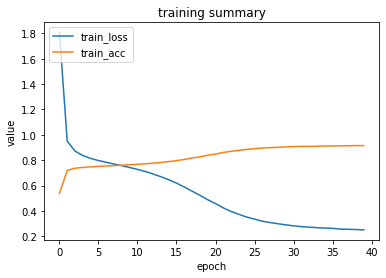

<Figure size 432x288 with 0 Axes>

In [ ]:
train(model, current_part, max_part, lastEpoch, model_type)

# Test

In [ ]:
from pickle import load
from keras.models import load_model
from keras.preprocessing.sequence import pad_sequences
import os
import re
import numpy as np
import argparse
import pickle
import codecs
import pandas as pd
import random
%tensorflow_version 1.x
import tensorflow as tf

# for tensor 1
config = tf.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
sess = tf.Session(config=config)
set_session(sess)
print("use-gpu:", tf.test.gpu_device_name())
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

bos = "{"
eos = "}"

use-gpu: /device:GPU:0
Num GPUs Available:  1


In [ ]:
 SEQ_LENGTH = 15
CORRECT_THRESHOLD = 0.001

In [ ]:
def to_upper_first_char(input_text):
	lst = input_text.lower().split()
	new_lst = []
	for item in lst:
		try:
			upper = item[0].upper()
			upper_val = mapping[item[0].upper()]
		except KeyError:
			upper = item[0]
		if len(item) > 1:
			new_item = upper + item[1:]
		else:
			new_item = upper + ''
		new_lst.append(new_item)
	return (" ".join(new_lst)).strip()

def text_cleaner(text):
	# INTAB = "ạảãàáâậầấẩẫăắằặẳẵóòọõỏôộổỗồốơờớợởỡéèẻẹẽêếềệểễúùụủũưựữửừứíìịỉĩýỳỷỵỹđẠẢÃÀÁÂẬẦẤẨẪĂẮẰẶẲẴÓÒỌÕỎÔỘỔỖỒỐƠỜỚỢỞỠÉÈẺẸẼÊẾỀỆỂỄÚÙỤỦŨƯỰỮỬỪỨÍÌỊỈĨÝỲỶỴỸĐ"
	newString = re.sub("[^a-zA-ZạảãàáâậầấẩẫăắằặẳẵóòọõỏôộổỗồốơờớợởỡéèẻẹẽêếềệểễúùụủũưựữửừứíìịỉĩýỳỷỵỹđẠẢÃÀÁÂẬẦẤẨẪĂẮẰẶẲẴÓÒỌÕỎÔỘỔỖỒỐƠỜỚỢỞỠÉÈẺẸẼÊẾỀỆỂỄÚÙỤỦŨƯỰỮỬỪỨÍÌỊỈĨÝỲỶỴỸĐ]", " ", text)
	# import pdb; pdb.set_trace()
	newString = to_upper_first_char(newString)
	newString = re.sub("[sđqxzZk]", "",newString)
	long_words=[]
	# remove short word
	for c, i in enumerate(newString.split()):
		# import pdb; pdb.set_trace()
		if (c == 0):
			i = bos + i

		if len(i)>=1:
			long_words.append(i)
		
	return (" ".join(long_words)).strip()

def encode_string(mapping, seq_length, in_text):
	# encode the characters as integers
	encoded = [mapping[char] for char in in_text]

	# truncate sequences to a fixed length
	encoded = pad_sequences([encoded], maxlen=seq_length, truncating='pre')
	return encoded

def decode_string(mapping, in_text):
	out_text = ""
	for i in range(len(in_text)):
		for char, index in mapping.items():
			if index == in_text[i]:
				out_text += char
				break
	return out_text

def insert(source_str, insert_str, pos):
    return source_str[:pos]+insert_str+source_str[pos:]

def replace(source_str, insert_str, start_pos):
	source_list = list(source_str)
	if (start_pos > len(source_list)):
		return source_str
	for i in range(len(insert_str)):
		source_list[start_pos + i] = insert_str[i]
	return ''.join(source_list)

In [ ]:
# load the model
model_type = input("Test with bidirectional model: ")
if model_type == '0':
  print('Standard LSTM')
  model = load_model('std_model/model.h5')
else:
  print('Bidirectional LSTM')
  model = load_model('bi_model/bi-model.h5')

# load the mapping
mapping = load(open('name_data_mapping.pkl' , 'rb'))

# vocabulary size
vocab_size = len(mapping)
print('Vocabulary Size: %d' % vocab_size)

print("Number of left layers: %d" % len(model.layers))

Test with bidirectional model: 1
Bidirectional LSTM
Vocabulary Size: 125
Number of left layers: 4


In [ ]:
idx_char_mapping = dict([(value, key) for key, value in mapping.items()]) 

## Predict the next character



In [ ]:
def next_char_predict(model, mapping, seq_length, seed_text, num=5):
  in_text = text_cleaner(seed_text)
  # print('===', in_text)
  out_text = in_text[:]
  # print(';;;;;;;;', out_text)
  i = len(in_text)

  out_text_predict_encode = encode_string(mapping, seq_length, out_text)
  # print('1:', out_text_predict_encode)
  proba_list_char = model.predict_proba(out_text_predict_encode)
  index_char_list = np.argsort(proba_list_char[0])[-num:][::-1]
  probability = proba_list_char[0][index_char_list]
  result = [idx_char_mapping[idx] for idx in index_char_list]
  # print('res1:', result)
  result = list(zip(result,list(probability)))
  return result

In [ ]:
while True:
    inputText = input('Input: ')
    output = inputText
    if (inputText == 'e'): break
    recs = next_char_predict(model, mapping, SEQ_LENGTH, inputText, num=5)

    for idx, res in enumerate(recs):
      print(f"Output {idx+1} :", output + res[0],"\t Probability:", res[1])
      # print(f"Output {idx+1} :", output + res)
    print('\n')

Input: Nguyễn 
Output 1 : Nguyễn } 	 Probability: 0.9999845
Output 2 : Nguyễn   	 Probability: 1.3865631e-05
Output 3 : Nguyễn p 	 Probability: 4.0244927e-07
Output 4 : Nguyễn g 	 Probability: 3.4540608e-07
Output 5 : Nguyễn ở 	 Probability: 1.6854196e-07


Input: e


## Correct one mistake


In [ ]:
def correct_one_mistake_multi_choice_with_proba(model, mapping, input_text, num=5):

	"""
	"""

	in_text = text_cleaner(input_text)
	# import pdb;pdb.set_trace()
	out_text_predict = in_text[0:8]
	i = 8
	results = ""
	proba_results = []
	proba_correct = 1.0
	while True:
		out_text_predict_encode = encode_string(mapping , SEQ_LENGTH, out_text_predict)
		proba_list_char = model.predict_proba(out_text_predict_encode)
		next_char = model.predict_classes(out_text_predict_encode)
		# import pdb; pdb.set_trace()
		if((i+1 <= len(in_text)) and int(next_char) != mapping[in_text[i]]):
			# import pdb; pdb.set_trace()
			if (proba_list_char[0][mapping[in_text[i]]] > CORRECT_THRESHOLD ):
				pass
			else:
				if (proba_list_char[0][mapping[in_text[i]]] < proba_correct): 
					proba_correct = proba_list_char[0][mapping[in_text[i]]]
					index_char_list = np.argpartition(proba_list_char, -num)[0,-num:]
					index_char_list = index_char_list[np.argsort(proba_list_char[0][index_char_list])][::-1]
					
					proba_results = proba_list_char[0, index_char_list]

					results = [in_text[:i] + idx_char_mapping[idx] + in_text[i+1:] for idx in index_char_list]
		else:
			pass
    
		if(i < len(in_text)-1):
			out_text_predict += in_text[i]
			i = i + 1
		else:
			break
	return results, proba_results

In [ ]:
while True:
    inputText = input('Input: ')
    if (inputText == 'e'): break
    results, c = correct_one_mistake_multi_choice_with_proba(model, mapping, inputText)
    for idx, out in enumerate(results):
      print(f"output {idx+1}: {out} -- with probality: {c[idx]}")

Input: Nguyễn Ngọh 
output 1: {Nguyễn Ngọc -- with probality: 0.999974250793457
output 2: {Nguyễn Ngọy -- with probality: 1.4062498848943505e-05
output 3: {Nguyễn Ngọ  -- with probality: 5.032165063312277e-06
output 4: {Nguyễn Ngọĩ -- with probality: 3.017276640093769e-06
output 5: {Nguyễn Ngọ} -- with probality: 2.663334043973009e-06
Input: e


## Correct all mistakes

In [ ]:
def correct(model, mapping, input_text):
    in_text = text_cleaner(input_text)
    # out_text = in_text[0:5]
    out_text_predict = in_text[0:8]
    # import pdb; pdb.set_trace()
    i = 8
    while True:
        out_text_predict_encode = encode_string(mapping , SEQ_LENGTH, out_text_predict)
        proba_list_char = model.predict_proba(out_text_predict_encode)
        next_char = model.predict_classes(out_text_predict_encode)
        # import pdb; pdb.set_trace()        
        if (i + 1 <= len(in_text) and (int(next_char) != mapping[in_text[i]])):
            if (proba_list_char[0][mapping[in_text[i]]] > CORRECT_THRESHOLD):
                # out_text += in_text[i]
                pass
        
            else:
                # To upper case the first character of word
                # import pdb; pdb.set_trace()
                new_char = np.argmax(proba_list_char[0])
                # import pdb;pdb.set_trace()
                if in_text[i] == ' ': 
                    space = ' '
                else:
                    space = ''
                in_text = out_text_predict + idx_char_mapping[new_char] + space + in_text[i+1:]

                # In case there is unwanted words spaces
                # import pdb; pdb.set_trace()
                in_text = " ".join(in_text.split())
                print ('mid-output: ' + in_text)
        else:
            pass
        
        if (i < len(in_text)-1):
            out_text_predict += in_text[i]
            i = i + 1
        else:
            break
    return in_text

In [ ]:
while True:
    inputText = input('Input: ')
    if (inputText == 'e'): break
    result = correct(model, mapping, inputText)
    result = re.sub("[^a-zA-ZạảãàáâậầấẩẫăắằặẳẵóòọõỏôộổỗồốơờớợởỡéèẻẹẽêếềệểễúùụủũưựữửừứíìịỉĩýỳỷỵỹđẠẢÃÀÁÂẬẦẤẨẪĂẮẰẶẲẴÓÒỌÕỎÔỘỔỖỒỐƠỜỚỢỞỠÉÈẺẸẼÊẾỀỆỂỄÚÙỤỦŨƯỰỮỬỪỨÍÌỊỈĨÝỲỶỴỸĐ]", " ", result).strip()
    
    # import pdb; pdb.set_trace() 
    # Niche for fixing last char error
    results, c = correct_one_mistake_multi_choice_with_proba(model, mapping, result, num=1)
    if len(results):
        result = re.sub("[^a-zA-ZạảãàáâậầấẩẫăắằặẳẵóòọõỏôộổỗồốơờớợởỡéèẻẹẽêếềệểễúùụủũưựữửừứíìịỉĩýỳỷỵỹđẠẢÃÀÁÂẬẦẤẨẪĂẮẰẶẲẴÓÒỌÕỎÔỘỔỖỒỐƠỜỚỢỞỠÉÈẺẸẼÊẾỀỆỂỄÚÙỤỦŨƯỰỮỬỪỨÍÌỊỈĨÝỲỶỴỸĐ]", " ", results[0]).strip()
    print(f"Final output: {result}")
    
    print('\n')

Input: Nguyễn nigc hải Đanng
mid-output: {Nguyễn Ninc Hải Đanng
mid-output: {Nguyễn Ninh Hải Đanng
mid-output: {Nguyễn Ninh Hải Đan}g
mid-output: {Nguyễn Ninh Hải Đan}
Final output: Nguyễn Ninh Hải Đan


Input: e


## Correcting with look ahead

In [ ]:
def search_future_space(remaining_depth, current_text, current_prob, possible_char_lst, model, mapping, seq_length):
    if remaining_depth == 0:
        return current_text, current_prob
    highest_prob_seq = None
    highest_prob = 0
    for item in possible_char_lst:
        # import pdb; pdb.set_trace()
        future_text = current_text + item[0]
        future_prob = current_prob*item[1]
        next_possible_char_lst = next_char_predict(model, mapping, seq_length, future_text, num=3)
        next_highest_prob_seq, next_highest_prob = search_future_space(remaining_depth - 1, future_text, future_prob, next_possible_char_lst, model, mapping, seq_length)
        # import pdb; pdb.set_trace()
        if next_highest_prob > highest_prob:
            highest_prob_seq = next_highest_prob_seq
            highest_prob = next_highest_prob
    return highest_prob_seq, highest_prob

In [ ]:
def correct_with_look_ahead(model, mapping, input_text):
    in_text = text_cleaner(input_text)
    # out_text = in_text[0:5]
    out_text_predict = in_text[0:8]
    # import pdb; pdb.set_trace()
    i = 8
    while True:
        out_text_predict_encode = encode_string(mapping , SEQ_LENGTH, out_text_predict)
        proba_list_char = model.predict_proba(out_text_predict_encode)
        next_char = model.predict_classes(out_text_predict_encode)
        # import pdb; pdb.set_trace()        
        if (i + 1 <= len(in_text) and (int(next_char) != mapping[in_text[i]])):
            if (proba_list_char[0][mapping[in_text[i]]] > CORRECT_THRESHOLD):
                # out_text += in_text[i]
                pass
        
            else:                
                remaining_depth = 5
                index_char_list = np.argsort(proba_list_char[0])[-3:][::-1]
                probability = proba_list_char[0][index_char_list]
                possible_char_lst = [idx_char_mapping[idx] for idx in index_char_list]
                possible_char_lst = list(zip(possible_char_lst,list(probability)))
                current_text = out_text_predict
                # import pdb; pdb.set_trace()
                seq, prob = search_future_space(remaining_depth, current_text, 1 ,possible_char_lst, model, mapping, SEQ_LENGTH)
                
                # import pdb; pdb.set_trace()
                seq_last_idx = remaining_depth - 1
                if seq[:-seq_last_idx][-1] == "}":
                    in_text = seq[:-seq_last_idx]
                else:
                    if in_text[i] == ' ': 
                        space = ' '
                    else:
                        space = ''
                    in_text = seq[:-seq_last_idx] + space + in_text[i+1:]

                # In case there is unwanted words spaces
                # import pdb; pdb.set_trace()
                in_text = " ".join(in_text.split())
                print ('mid-output: ' + in_text)

        else:
            pass
        
        if (i < len(in_text)-1):
            out_text_predict += in_text[i]
            i = i + 1
        else:
            break
    return in_text

In [ ]:
while True:
    inputText = input('Input: ')
    if (inputText == 'e'): break
    result = correct_with_look_ahead(model, mapping, inputText)
    result = re.sub("[^a-zA-ZạảãàáâậầấẩẫăắằặẳẵóòọõỏôộổỗồốơờớợởỡéèẻẹẽêếềệểễúùụủũưựữửừứíìịỉĩýỳỷỵỹđẠẢÃÀÁÂẬẦẤẨẪĂẮẰẶẲẴÓÒỌÕỎÔỘỔỖỒỐƠỜỚỢỞỠÉÈẺẸẼÊẾỀỆỂỄÚÙỤỦŨƯỰỮỬỪỨÍÌỊỈĨÝỲỶỴỸĐ]", " ", result).strip()
    print(f"Final output: {result}")
    
    print('\n')

Input: Nguyễn ngic Hai Đnng
mid-output: {Nguyễn Ngọc Hai Đnng
mid-output: {Nguyễn Ngọc Hai Đăng
Final output: Nguyễn Ngọc Hai Đăng


Input: Trương Tuen Aanh
mid-output: {Trương Tuấn Aanh
mid-output: {Trương Tuấn Annh
mid-output: {Trương Tuấn Anhh
mid-output: {Trương Tuấn Anh}
Final output: Trương Tuấn Anh


Input: Nguyễn Thenh Suung
mid-output: {Nguyễn Thành Suung
mid-output: {Nguyễn Thành Saung
mid-output: {Nguyễn Thành Sanng
mid-output: {Nguyễn Thành Sangg
mid-output: {Nguyễn Thành Sang}
Final output: Nguyễn Thành Sang


Input: e
